In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
sys.path.append("..")
import keras_utils
import keras
print(keras.__version__)
import tqdm_utils

1.11.0
2.2.4


Using TensorFlow backend.


In [2]:
start_token = " "  # so that the network knows that we're generating a first token

# this is the token for padding,
# we will add fake pad token at the end of names 
# to make them of equal size for further batching
pad_token = "#"

with open("peptides.txt") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + name for name in names]

('max length:', 159)


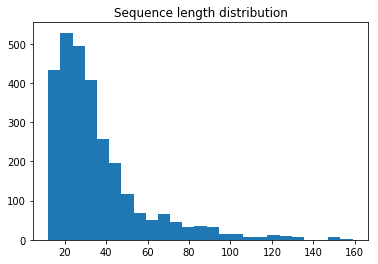

In [3]:
MAX_LENGTH = max(map(len, names))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=25);

In [4]:
tokens = set(''.join(names)) 
tokens.add(pad_token)
print(tokens)

tokens = list(tokens)
n_tokens = len(tokens)
print ('n_tokens:', n_tokens)


set([' ', '#', 'A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 'Y'])
('n_tokens:', 22)


In [5]:
token_to_id = {s : i for i, s in enumerate(tokens)} ### YOUR CODE HERE: create a dictionary of {symbol -> its  index in tokens}

assert len(tokens) == len(token_to_id), "dictionaries must have same size"
print(token_to_id)

{' ': 0, '#': 1, 'A': 2, 'C': 3, 'E': 4, 'D': 5, 'G': 6, 'F': 7, 'I': 8, 'H': 9, 'K': 10, 'M': 11, 'L': 12, 'N': 13, 'Q': 14, 'P': 15, 'S': 16, 'R': 17, 'T': 18, 'W': 19, 'V': 20, 'Y': 21}


In [6]:
def to_matrix(names, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):
    """Casts a list of names into rnn-digestable padded matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [7]:
# Example: cast 4 random names to padded matrices (so that we can easily batch them)
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

 SLFSLIKAGAKFLGKNLLKQGACYAACKASKQC
 FALGAVTKLLPSLLCMITRKC
[[ 0 16 12  7 16 12  8 10  2  6  2 10  7 12  6 10 13 12 12 10 14  6  2  3
  21  2  2  3 10  2 16 10 14  3]
 [ 0  7  2 12  6  2 20 18 10 12 12 15 16 12 12  3 11  8 18 17 10  3  1  1
   1  1  1  1  1  1  1  1  1  1]]


In [8]:
# remember to reset your session if you change your graph!
s = keras_utils.reset_tf_session()

In [11]:
import keras
from keras.layers import concatenate, Dense, Embedding

rnn_num_units = 73  # size of hidden state
embedding_size = 17  # for characters


# an embedding layer that converts character ids into embeddings
embed_x = Embedding(n_tokens, embedding_size)

# a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
get_h_next = Dense(rnn_num_units, activation='sigmoid') 

# a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
get_probas = Dense(n_tokens, activation='softmax') 

In [13]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces 
    probabilities for next token x_t+1 and next state h_t+1
    given current input x_t and previous state h_t.
    We'll call this method repeatedly to produce the whole sequence.
    
    You're supposed to "apply" above layers to produce new tensors.
    Follow inline instructions to complete the function.
    """
    # convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    
    # concatenate x_t embedding and previous h_t state
    x_and_h = concatenate([x_t_emb, h_t]) 
    
    # compute next state given x_and_h
    h_next = get_h_next(x_and_h) 
    
    # get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next) 
    
    return output_probas, h_next

In [14]:
input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))  # batch of token ids
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])  # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
# combine predicted_probas into [batch, time, n_tokens] tensor
predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])

# next to last token prediction is not needed
predicted_probas = predicted_probas[:, :-1, :]

In [15]:
# flatten predictions to [batch*time, n_tokens]
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])

# flatten answers (next tokens) and one-hot encode them
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

In [16]:
loss = -tf.reduce_mean(answers_matrix * tf.log(predictions_matrix)) ### YOUR CODE HERE

optimize = tf.train.AdamOptimizer().minimize(loss)

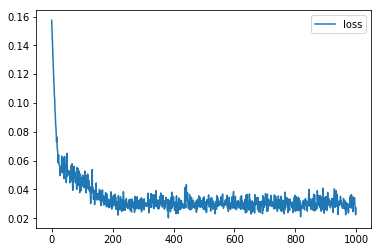

In [18]:
from IPython.display import clear_output
from random import sample

s.run(tf.global_variables_initializer())

batch_size = 32
history = []

for i in range(1000):
    batch = to_matrix(sample(names, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()
        
assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge"        

In [19]:
x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))  # we will update hidden state in this variable

# For sampling we need to define `rnn_one_step` tensors only once in our graph.
# We reuse all parameters thanks to functional API usage.
# Then we can feed appropriate tensor values using feed_dict in a loop.
# Note how different it is from training stage, where we had to unroll the whole sequence for backprop.
next_probs, next_h = rnn_one_step(x_t, h_t)

In [20]:
def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
    '''
    This function generates text given a `seed_phrase` as a seed.
    Remember to include start_token in seed phrase!
    Parameter `max_length` is used to set the number of characters in prediction.
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))
    
    # feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    # start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])

In [21]:
# without prefix
for _ in range(10):
    print(generate_sample())

 GGYTPVKTMLLSAARAR
 NAQTFKLGENDACAGIGKIPTIKCI
 GSEAMVLYNLRKLGHSRVILQSTLPKCISFTIAHTEYVANKRTHYCLKMWEH
 FLQCGIMVVSLGEALIPCAQKIWKDGYGKRGDPLASFTWGKHGLDAYFAIVGKKENEQFLKSQNNYVGRGIESSLWLFCFLSPRPVSREFDVWIWDIVTIDRMAISAGMEHKRMSQVTQNNPKLYTEHQDKPMVYAGGYTEKSESGYMKGFGRDLELF
 LLKYKSRW


KeyboardInterrupt: 